In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nb

from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torchvision.transforms as transforms

In [10]:
BASE_DIR="./brains/"
#TRAIN_IMAGES_DIR=os.path.join(BASE_DIR,'train_images')

data_df=pd.read_excel('Classification_clean.xlsx')
data_df["Class"]=data_df["Diagnosis"]>0
#data_df["Class"].replace(True,2,inplace=True)
#data_df["Class"].replace(False,1,inplace=True)
data_df.Class = data_df.Class.astype('int')


data_df.head()

,ID_CF,FirstEpisodes_FEP__HealthyControl_HC_,Diagnosis,Gender,Age,Site 1,Site 2,Site 3,Site 4,Site 5,Site 6,Site 7,Euler,Class
0,CF_001,FEP,3,0,23.857632,0,0,0,0,0,0,0,-21,1
1,CF_002,FEP,3,0,28.952772,0,0,0,0,0,0,0,-33,1
2,CF_003,FEP,1,0,20.199863,0,0,0,0,0,0,0,-55,1
3,CF_004,FEP,1,0,28.517454,0,0,0,0,0,0,0,-26,1
4,CF_005,FEP,2,1,39.101985,0,0,0,0,0,0,0,-24,1


In [14]:
class Milano_MRI_Dataset(Dataset):
    def __init__(self,df:pd.DataFrame,imfolder:str,train:bool = True, transforms=None):
        self.df=df
        self.imfolder=imfolder
        self.train=train
        #self.transforms=transforms
        
    def __getitem__(self,index):
        filename='w'+self.df.iloc[index]['ID_CF']+'_MRI_sMRI_'+self.df.iloc[index]['ID_CF']+'_brain.nii.gz';
        
        im_path=os.path.join(self.imfolder,filename)
        
        nimg = nb.load(im_path)
        x = np.array(nimg.dataobj)
        #x=nimg.get_fdata()
        x = transforms.ToTensor()(x)
        x=x.unsqueeze(0).type(torch.FloatTensor);
        m=torch.mean(x)
        s=torch.std(x)
        x=(x-m)/s
        #if(self.transforms):
        #    x=self.transforms(image=x)['image']
        
        if(self.train):
            y=self.df.iloc[index]['Class']
            return x,y
        else:
            return x
        
    def __len__(self):
        return len(self.df)




In [15]:
train, valid = train_test_split(
    data_df, 
    test_size=0.2, 
    random_state=42,
    stratify=data_df.Class.values
)



# reset index on both dataframes
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)

train_targets = train.Class.values

# targets for validation
valid_targets = valid.Class.values

train_dataset=Milano_MRI_Dataset(
    df=train,
    imfolder=BASE_DIR,
    train=True,
    transforms=None
)

valid_dataset=Milano_MRI_Dataset(
    df=valid,
    imfolder=BASE_DIR,
    train=True,
    transforms=None
)

train_loader = DataLoader(
    train_dataset,
    batch_size=15,
    #num_workers=4,
    shuffle=True,
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=15,
    #num_workers=4,
    shuffle=False,
)

# A simple 3D CNN 

In [5]:
import torch
import torch.nn as nn
import math
from functools import partial
from torch.autograd import Variable

import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import time
import datetime
import copy

In [6]:
class Simple3DCNN(nn.Module):

    def __init__(self, num_classes):

        
        super(Simple3DCNN, self).__init__()

        self.conv_layer1 = self._make_conv_layer(1, 32)
        self.conv_layer2 = self._make_conv_layer(32, 64)
        self.conv_layer3 = self._make_conv_layer(64, 128)
        self.conv_layer4 = self._make_conv_layer(128, 256)
        self.conv_layer5=nn.Conv3d(256, 2048, kernel_size=(4, 4, 5), padding=0)
        
        self.fc5 = nn.Linear(2048, 512)
        self.relu = nn.LeakyReLU()
        self.batch0=nn.BatchNorm1d(512)
        self.drop=nn.Dropout(p=0.25)        
        self.fc6 = nn.Linear(512, 256)
        self.relu = nn.LeakyReLU()
        self.batch1=nn.BatchNorm1d(256)
        
        self.drop=nn.Dropout(p=0.25)
        self.fc7 = nn.Linear(256, num_classes)

    def _make_conv_layer(self, in_c, out_c):
        conv_layer = nn.Sequential(
        nn.Conv3d(in_c, out_c, kernel_size=3, padding=1),
        nn.LeakyReLU(),
        #nn.Conv3d(out_c, out_c, kernel_size=3, padding=1),
        #nn.LeakyReLU(),
        nn.BatchNorm3d(out_c),
        nn.MaxPool3d(kernel_size=2, stride=2),
        )
        return conv_layer

    def forward(self, x):
        #print(x.size())
        x = self.conv_layer1(x)
        #print(x.size())
        x = self.conv_layer2(x)
        #print(x.size())
        x = self.conv_layer3(x)
        #print(x.size())
        x = self.conv_layer4(x)
        #print(x.size())
        x=self.conv_layer5(x)
        #print(x.size())
        x = x.view(x.size(0), -1)
        #print(x.size())
        x = self.fc5(x)
        x = self.relu(x)
        #print(x.size())
        x = self.batch0(x)
        x = self.drop(x)
        x = self.fc6(x)
        x = self.relu(x)
        x = self.batch1(x)
        x = self.drop(x)
        x = self.fc7(x)

        return x#,x1

In [7]:
model = Simple3DCNN(2)

In [ ]:
tmp=next(iter(train_loader))
out=model(tmp[0])

# Defining the training function

In [ ]:
def train_model(datasets, dataloaders, model, criterion, optimizer, scheduler, num_epochs, device):
    
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs-1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0.0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels=labels.to(device)

                # Zero out the grads
                optimizer.zero_grad()

                # Forward
                # Track history in train mode
                with torch.set_grad_enabled(phase == 'train'):
                    model=model.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #loss = criterion(outputs, labels.type(torch.LongTensor).unsqueeze(1).to(device))
                    loss = criterion(outputs, labels.type(torch.LongTensor).to(device))

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # Statistics
                running_loss += loss.item()*inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss/len(datasets[phase])
            epoch_acc = running_corrects.double()/len(datasets[phase])

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time()-since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

# Training

In [ ]:
class_sample_count = np.array([len(np.where(train_targets == t)[0]) for t in np.unique(train_targets)])
weight = 1. / class_sample_count
class_weight=torch.from_numpy(weight)
class_weight=class_weight.max()/class_weight
class_weight=class_weight/class_weight.max()
class_weight=class_weight.type(torch.FloatTensor)
print(class_weight)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

datasets={'train':train_dataset,'valid':valid_dataset}
dataloaders={'train':train_loader,'valid':valid_loader}

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-6, weight_decay=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=100, gamma=0.1)

criterion=nn.CrossEntropyLoss()
#criterion=nn.BCEWithLogitsLoss()

num_epochs=2000

trained_model=train_model(datasets,dataloaders,model,criterion,optimizer,scheduler,num_epochs,device)


In [22]:
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz

tmp=next(iter(train_loader))
out=model(tmp[0])

layer_gradcam = LayerGradCam(model, model.conv_layer4)
attributions_lgc = layer_gradcam.attribute(tmp[0], target=0)

In [26]:
upsamp_attr_lgc = LayerAttribution.interpolate(attributions_lgc, tmp[0].size()[2:])

In [28]:
upsamp_attr_lgc.size()

torch.Size([15, 1, 79, 79, 95])

TypeError: Invalid shape (79, 79, 1) for image data

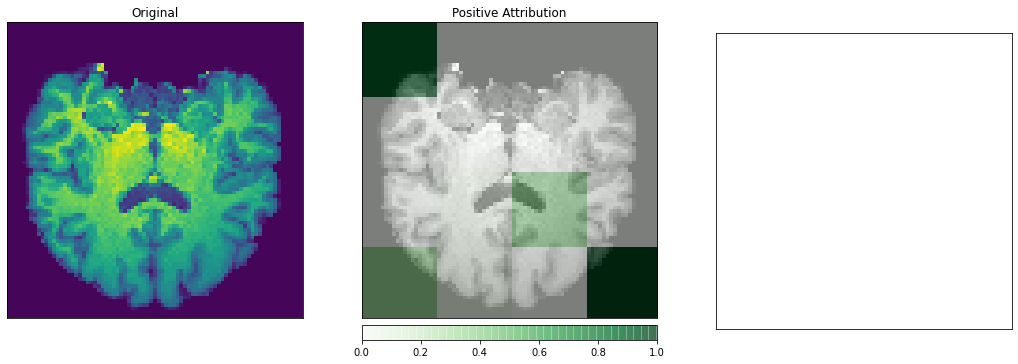

In [36]:
_ = viz.visualize_image_attr_multiple(upsamp_attr_lgc[0,:,:,:,50].cpu().permute(1,2,0).detach().numpy(),
                                      tmp[0][0,:,:,:,50].cpu().permute(1,2,0).numpy(),
                                      ["original_image","blended_heat_map","masked_image"],
                                      ["all","positive","positive"],
                                      show_colorbar=True,
                                      titles=["Original", "Positive Attribution", "Masked"],
                                      fig_size=(18, 6))

In [31]:
tmp[0,:,:,:,50].size()

TypeError: list indices must be integers or slices, not tuple